<a href="https://colab.research.google.com/github/christian-ian-dev/Estimation-of-Obesity-Levels/blob/main/Estimation_of_Obesity_Levels__Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install the official UCI Machine Learning Repository library
!pip install ucimlrepo

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
from ucimlrepo import fetch_ucirepo

# Dataset using its ID (544)
obesity_data = fetch_ucirepo(id=544)

# Separate features (X) and targets (y)
X = obesity_data.data.features
y = obesity_data.data.targets

# Combine the DataFrame for easier exploration
df = pd.concat([X, y], axis=1)

# Display the first few rows
print("Dataset Loaded Successfully!")
display(df.head())

Dataset Loaded Successfully!


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [3]:
# Checking data types and missing values
print("--- Data Info ---")
df.info()

print("\n--- Summary Statistics ---")
display(df.describe())

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF             

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


/tmp/ipython-input-1001406511.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


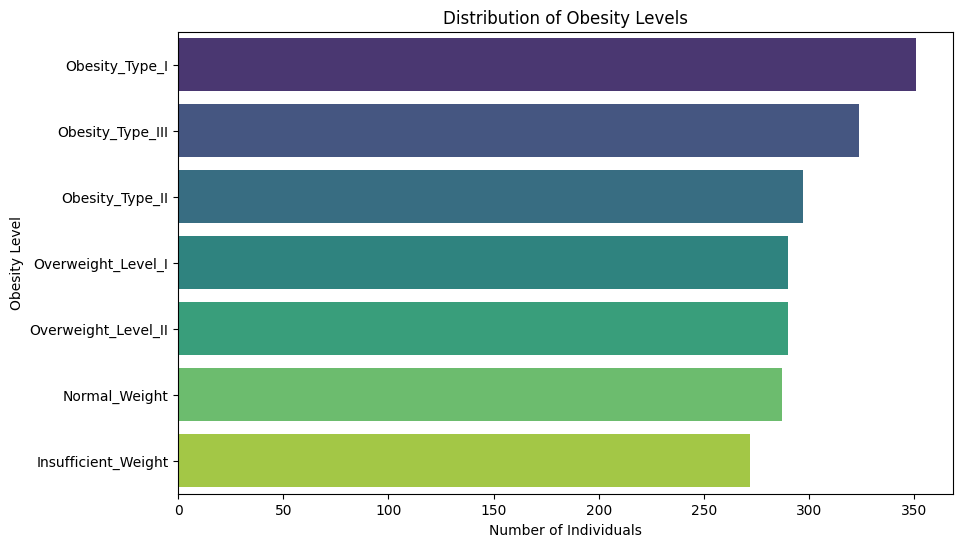

In [4]:
# Figure size
plt.figure(figsize=(10, 6))

# Count plot: target variable 'NObeyesdad'
sns.countplot(
    y='NObeyesdad',
    data=df,
    order=df['NObeyesdad'].value_counts().index,
    palette='viridis'
)

plt.title('Distribution of Obesity Levels')
plt.xlabel('Number of Individuals')
plt.ylabel('Obesity Level')

plt.show()

**Exploratory Data Analysis**

In [5]:
# Count occurrences of each obesity level
counts = df['NObeyesdad'].value_counts()

# Define the groups as requested
insufficient =  + counts.get('Insufficient_Weight', 0)
normal_weight = counts.get('Normal_Weight', 0)
overweight = counts.get('Overweight_Level_I', 0) + counts.get('Overweight_Level_II', 0)
obese = counts.get('Obesity_Type_I', 0) + counts.get('Obesity_Type_II', 0) + counts.get('Obesity_Type_III', 0)

# Display the results
summary_counts = pd.Series({
    'Insufficient': insufficient,
    'Normal': normal_weight,
    'Overweight': overweight,
    'Obese': obese
})

print("Number of individuals by grouped categories:")
print(summary_counts)

Number of individuals by grouped categories:
Insufficient    272
Normal          287
Overweight      580
Obese           972
dtype: int64


In [6]:
# separate numerical and categorical features

numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = df.select_dtypes(include=["object"]).columns

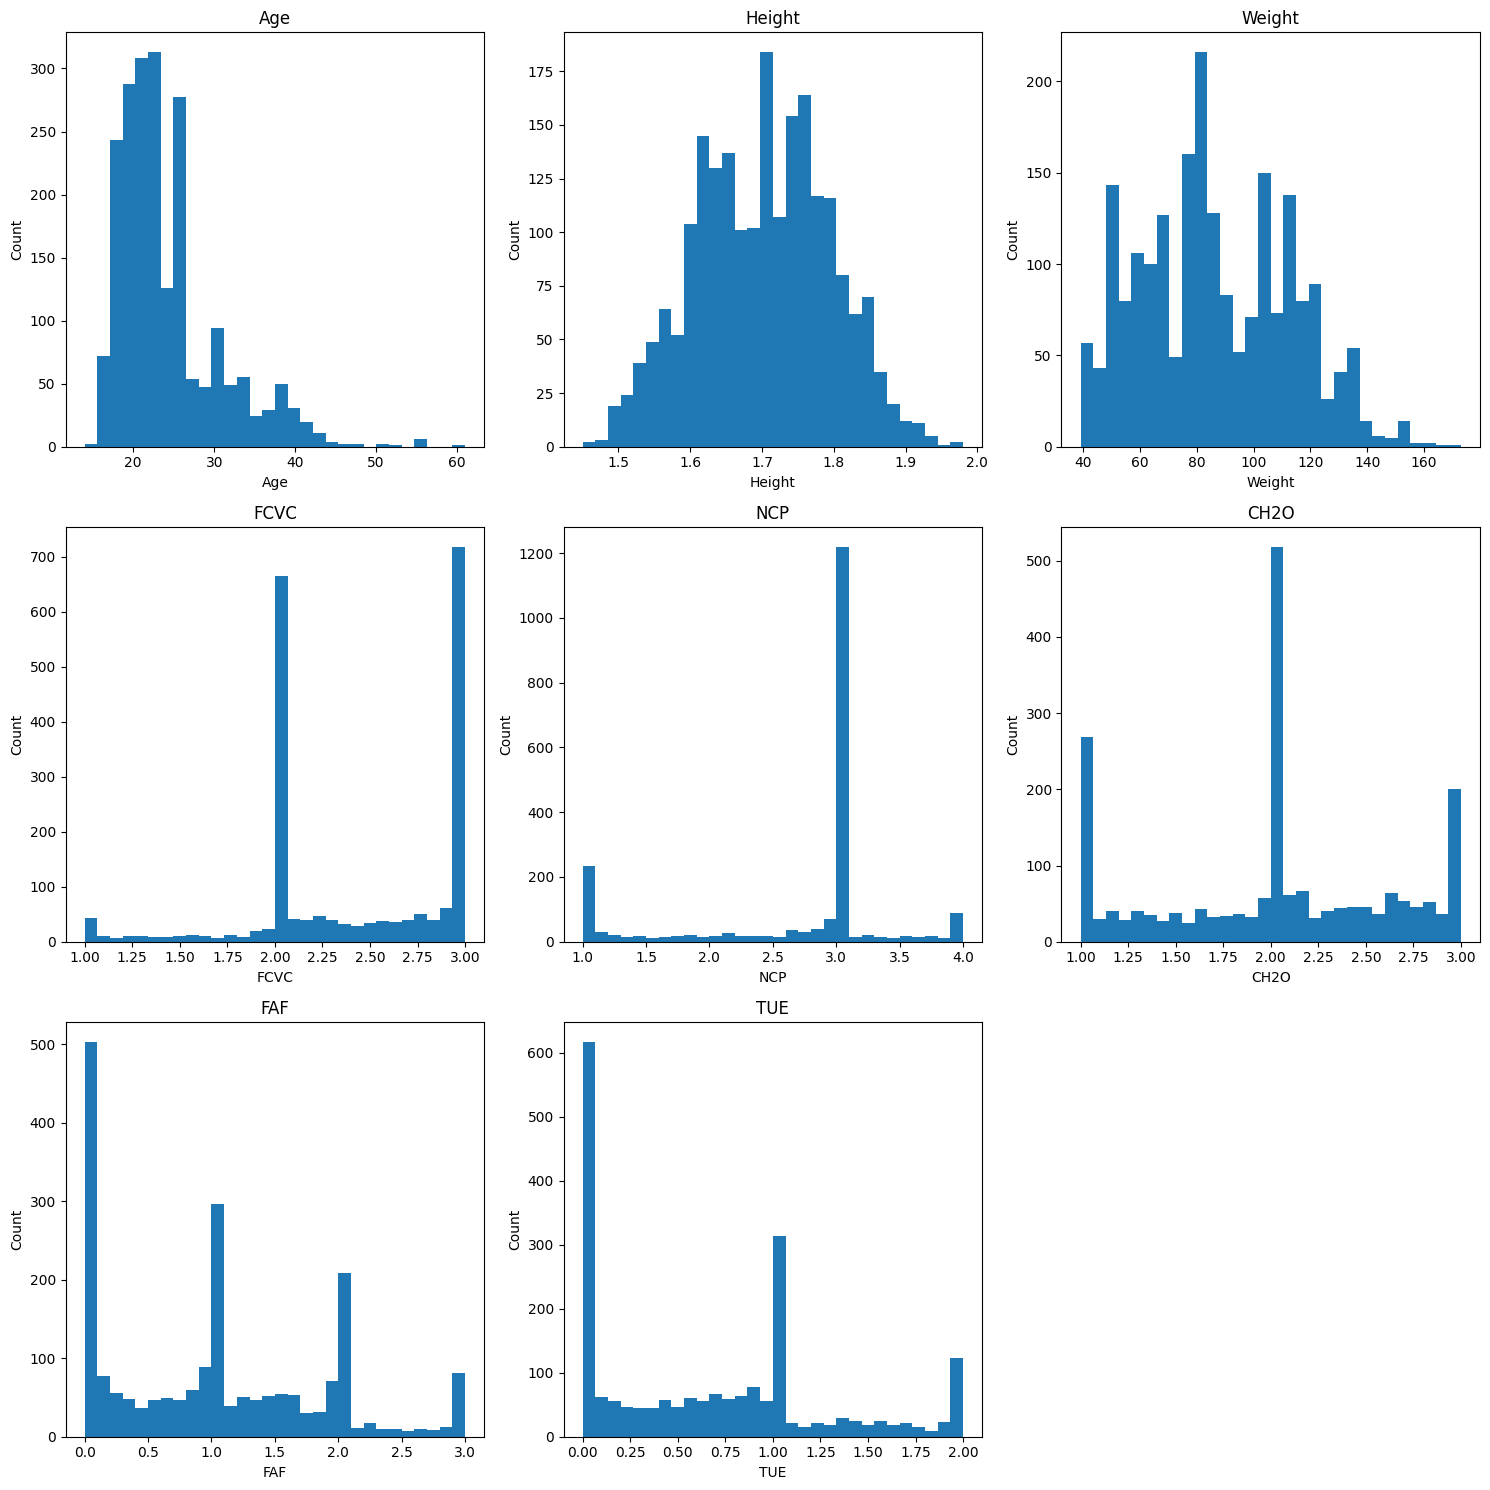

In [7]:
# EDA for numeric features

cols_per_row = 3
num_plots = len(numeric_cols)
num_rows = math.ceil(num_plots / cols_per_row)

plt.figure(figsize=(15, 5 * num_rows))

for i, col in enumerate(numeric_cols):
    plt.subplot(num_rows, cols_per_row, i + 1)
    plt.hist(df[col].dropna(), bins=30)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

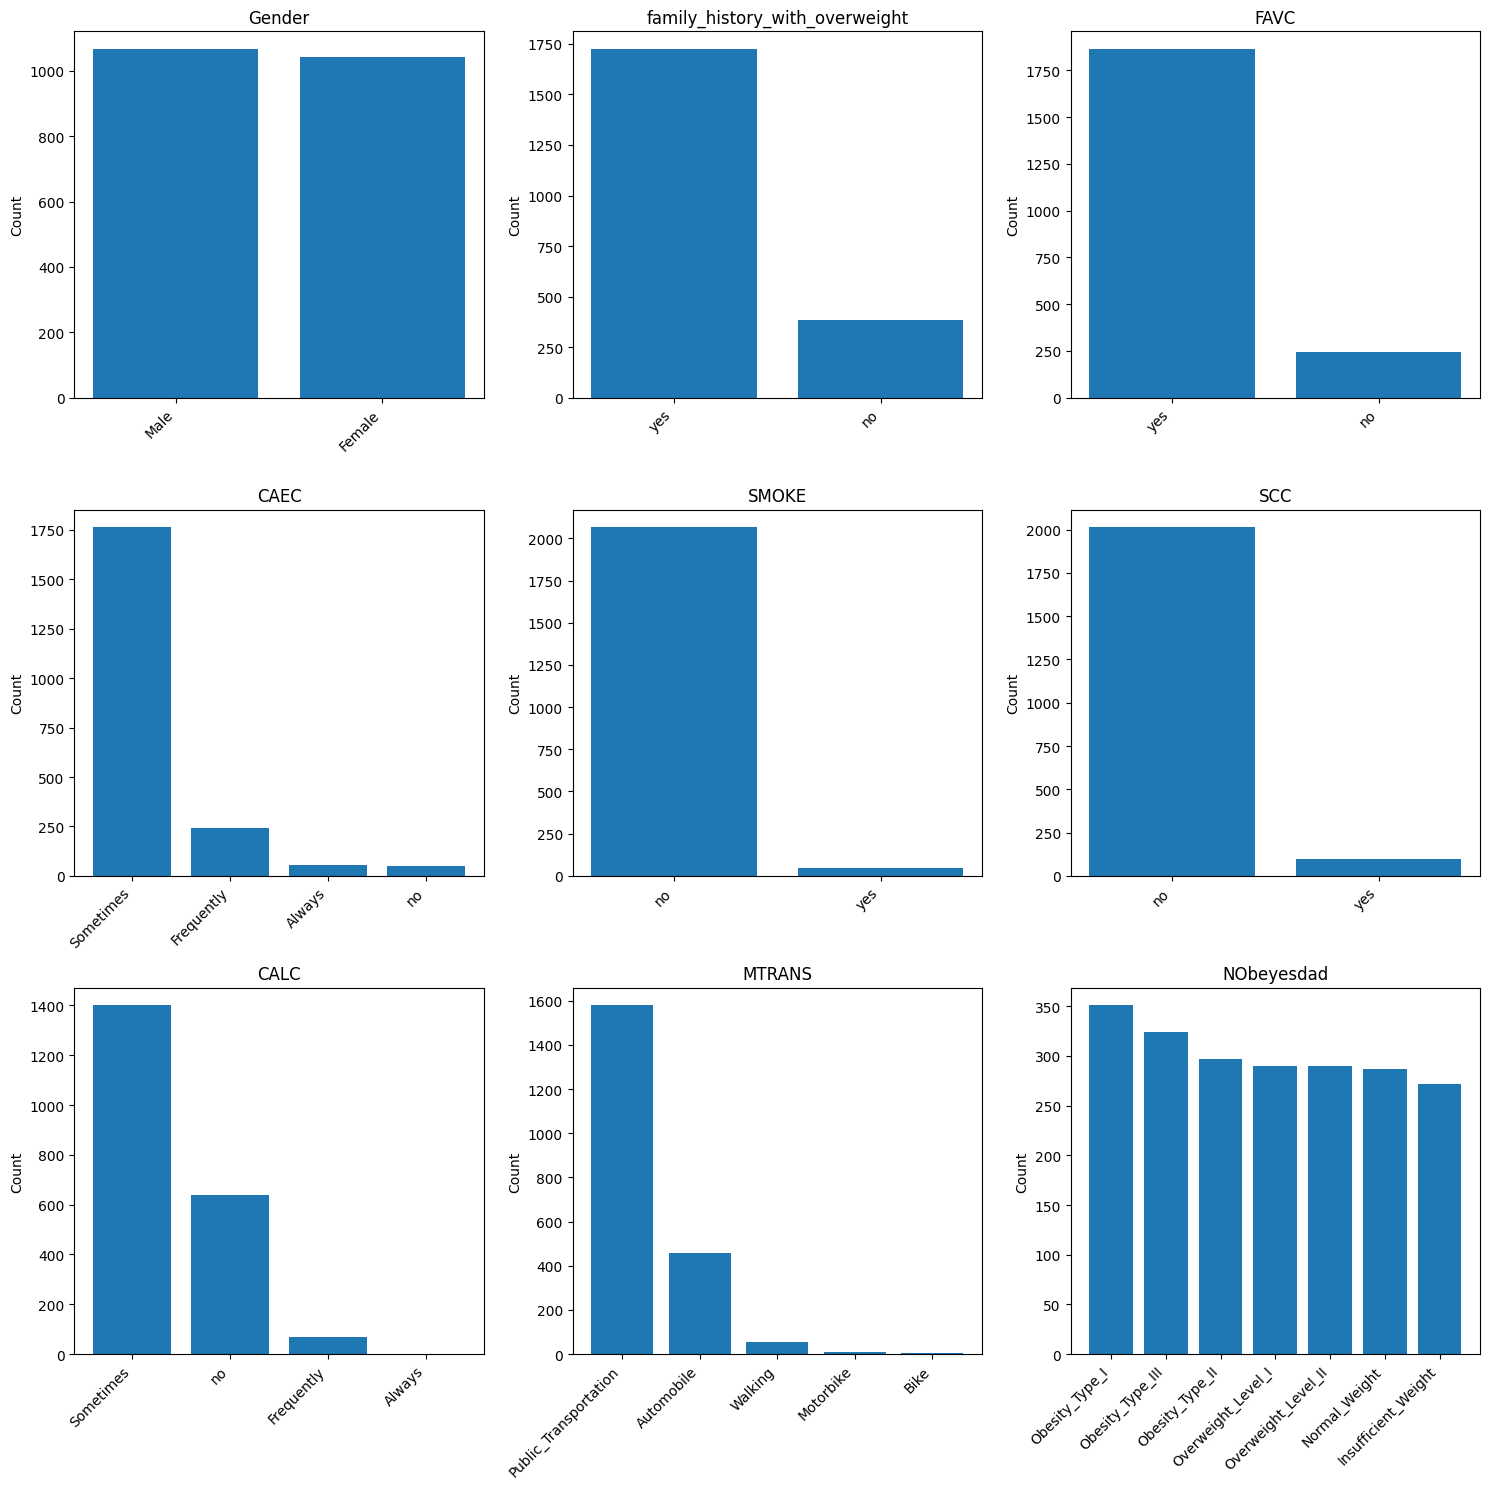

In [8]:
# EDA for categorical features

cols_per_row = 3
num_plots = len(categorical_cols)
num_rows = math.ceil(num_plots / cols_per_row)

plt.figure(figsize=(15, 5 * num_rows))

for i, col in enumerate(categorical_cols):
    counts = df[col].value_counts()

    plt.subplot(num_rows, cols_per_row, i + 1)
    plt.bar(counts.index.astype(str), counts.values)
    plt.title(col)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


# **What are the Associations between Obesity Levels and the other Features?**



/tmp/ipython-input-1194841308.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
/tmp/ipython-input-1194841308.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
/tmp/ipython-input-1194841308.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
/tmp/ipython-input-1194841308.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
/tmp/ipython-input-1194841308.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 

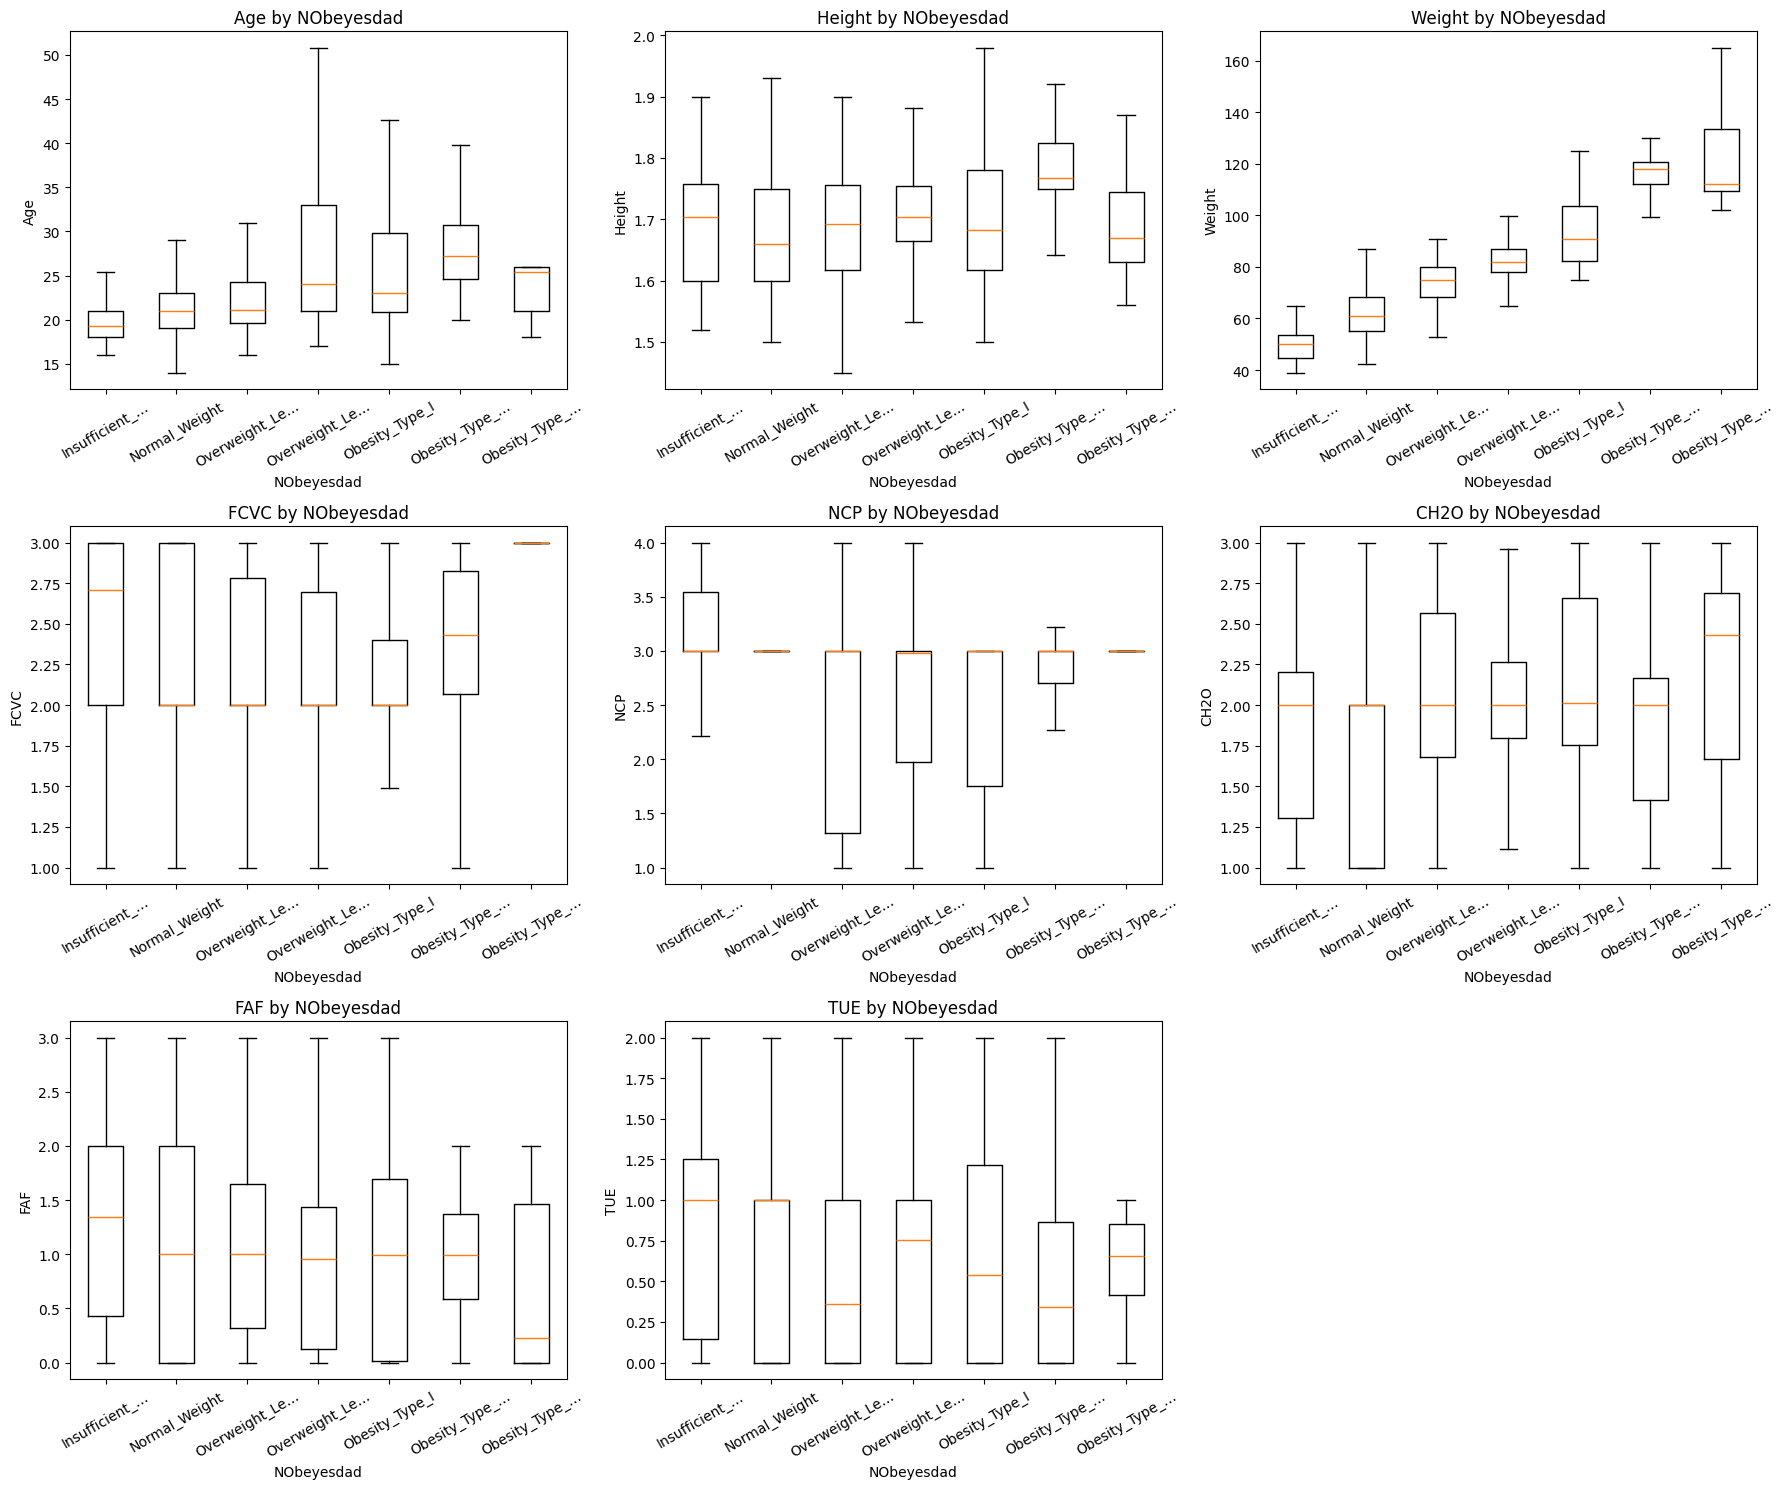

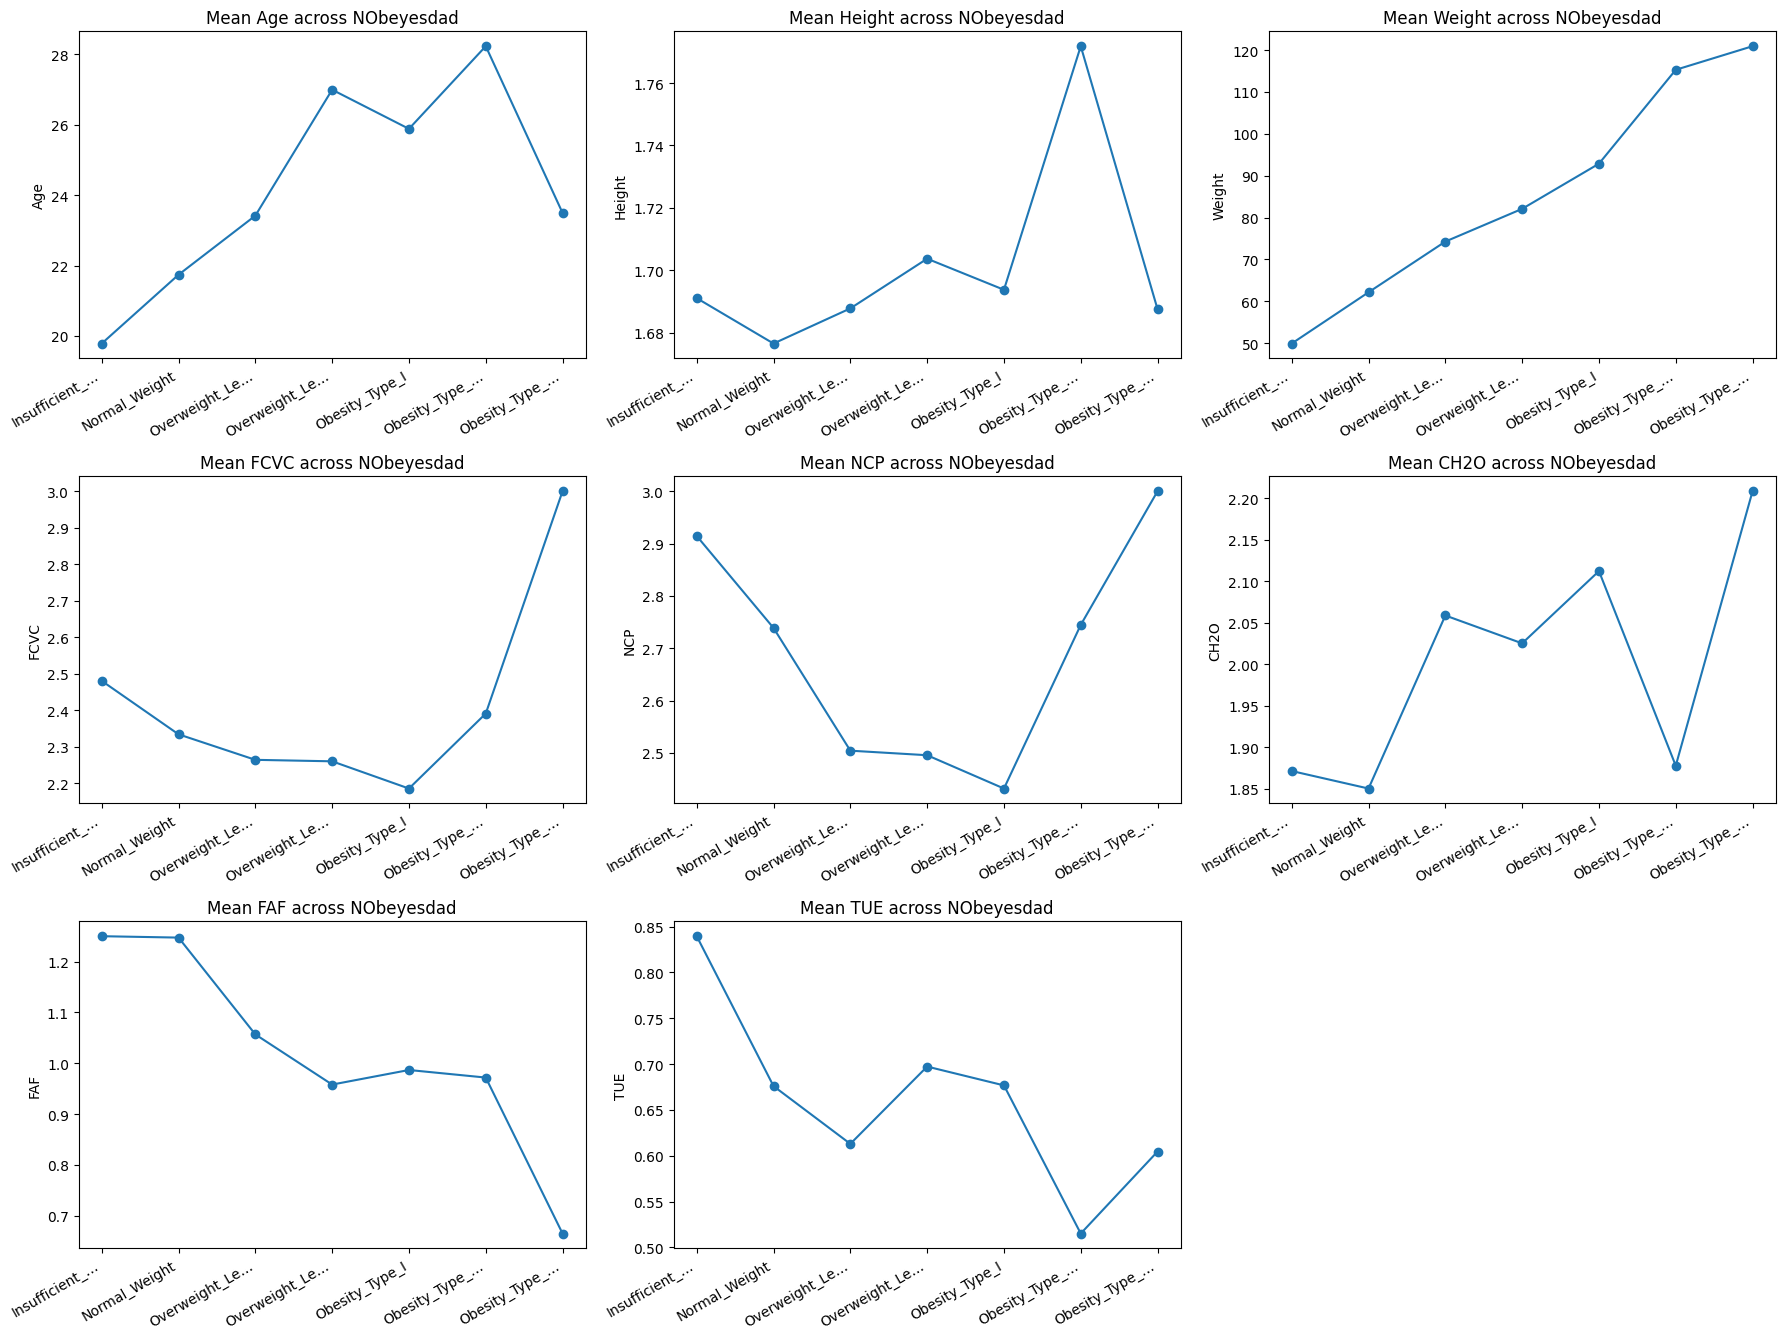

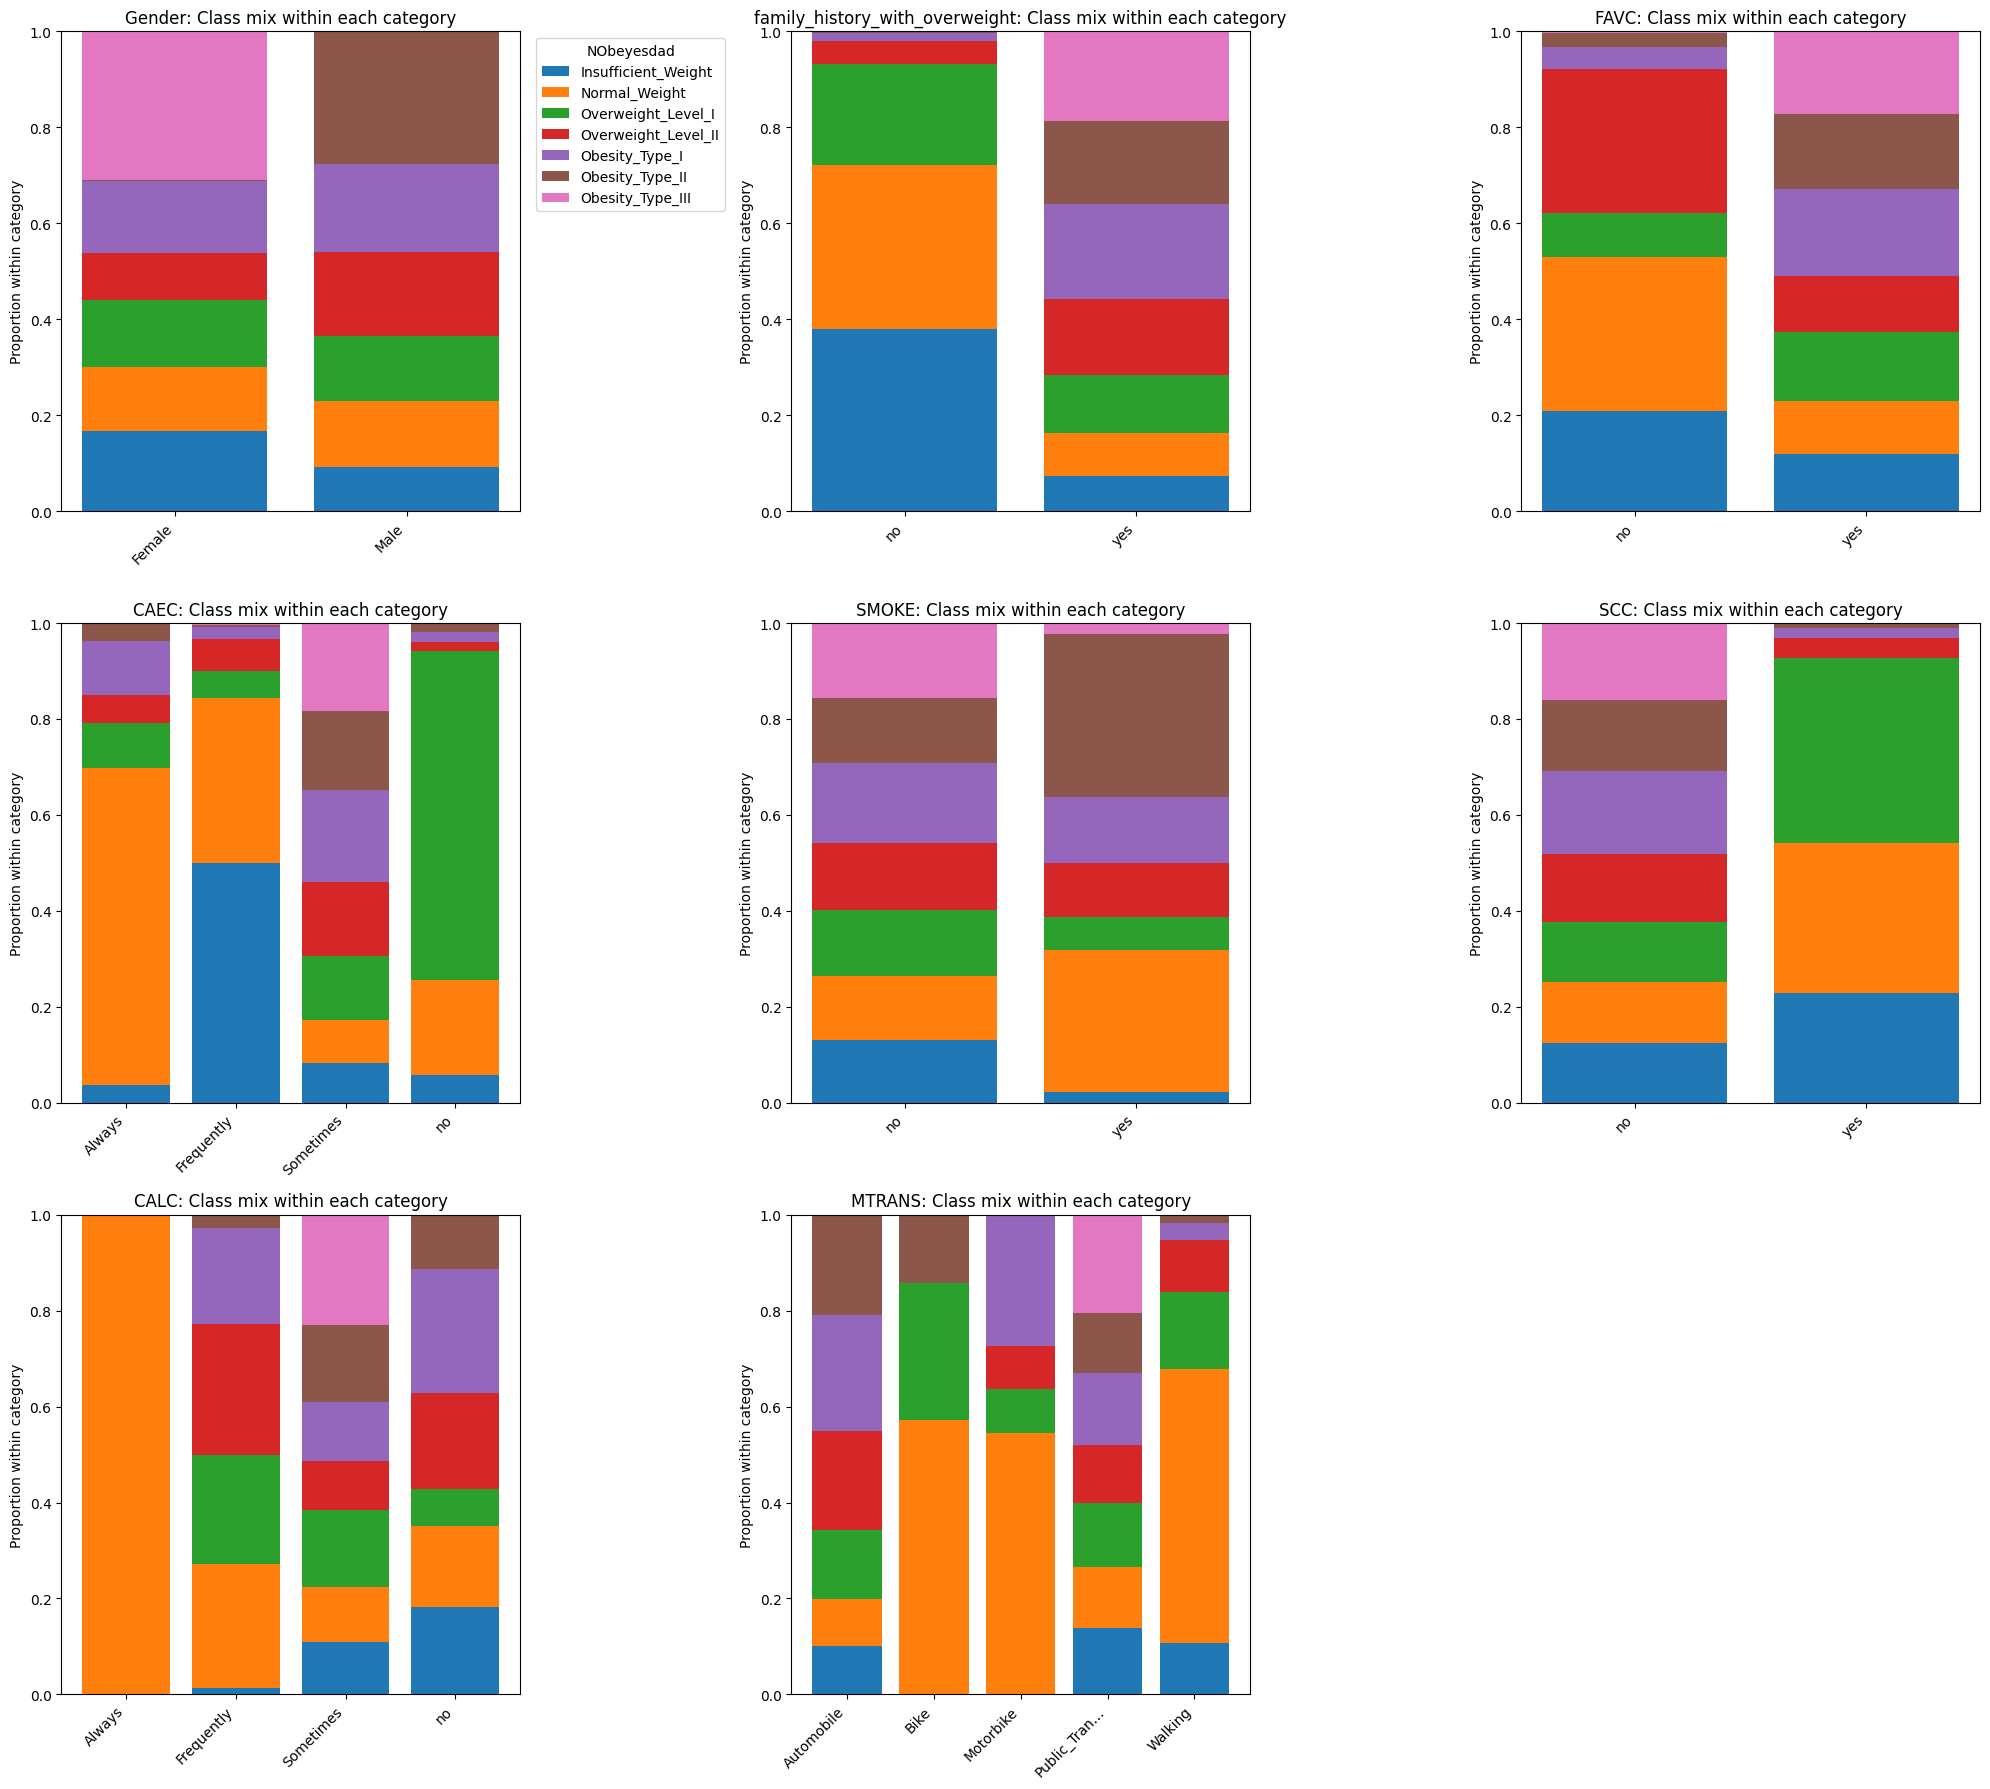

=== Missingness (fraction missing) ===
Gender                            0.0
Age                               0.0
Height                            0.0
Weight                            0.0
family_history_with_overweight    0.0
FAVC                              0.0
FCVC                              0.0
NCP                               0.0
CAEC                              0.0
SMOKE                             0.0
CH2O                              0.0
SCC                               0.0
FAF                               0.0
TUE                               0.0
CALC                              0.0
MTRANS                            0.0
NObeyesdad                        0.0
dtype: float64

=== Rare categories (count < 20) ===

CALC:
CALC
Always    1
Name: count, dtype: int64

MTRANS:
MTRANS
Motorbike    11
Bike          7
Name: count, dtype: int64


In [9]:
import numpy as np

TARGET = "NObeyesdad"
assert TARGET in df.columns, f"Expected target column '{TARGET}' not found."

# Optional: set a stable class order (edit if your dataset uses different labels)
# If you don't know the exact labels, comment this out and it will use alphabetical order.
ordered_classes = [
    "Insufficient_Weight",
    "Normal_Weight",
    "Overweight_Level_I",
    "Overweight_Level_II",
    "Obesity_Type_I",
    "Obesity_Type_II",
    "Obesity_Type_III",
]
if set(ordered_classes).issubset(set(df[TARGET].dropna().unique())):
    class_order = ordered_classes
else:
    class_order = sorted(df[TARGET].dropna().unique())

# Split features
numeric_cols = [c for c in df.select_dtypes(include=["int64", "float64"]).columns if c != TARGET]
categorical_cols = [c for c in df.select_dtypes(include=["object"]).columns if c != TARGET]

# Helper: small function to keep plots readable
def _shorten_labels(labels, maxlen=12):
    out = []
    for x in labels:
        s = str(x)
        out.append(s if len(s) <= maxlen else s[:maxlen-1] + "…")
    return out

# ==========================================================
# 1) NUMERIC FEATURES: Boxplots vs NObeyesdad (3 per row)
# ==========================================================
cols_per_row = 3
num_plots = len(numeric_cols)
num_rows = math.ceil(num_plots / cols_per_row)

fig = plt.figure(figsize=(18, 5 * num_rows))

for i, col in enumerate(numeric_cols):
    ax = fig.add_subplot(num_rows, cols_per_row, i + 1)

    # Gather data in class order
    data = [df.loc[df[TARGET] == cls, col].dropna().values for cls in class_order]

    ax.boxplot(
        data,
        labels=_shorten_labels(class_order, maxlen=14),
        showfliers=False  # reduce clutter
    )
    ax.set_title(f"{col} by {TARGET}")
    ax.set_xlabel(TARGET)
    ax.set_ylabel(col)
    ax.tick_params(axis="x", rotation=30)

plt.tight_layout()
plt.show()

# ==========================================================
# 2) NUMERIC FEATURES: Mean-by-class line plots (3 per row)
#    (Great for spotting monotonic trends across ordered classes)
# ==========================================================
num_rows = math.ceil(num_plots / cols_per_row)
fig = plt.figure(figsize=(18, 4.5 * num_rows))

means = (
    df.groupby(TARGET)[numeric_cols]
      .mean(numeric_only=True)
      .reindex(class_order)
)

for i, col in enumerate(numeric_cols):
    ax = fig.add_subplot(num_rows, cols_per_row, i + 1)
    ax.plot(range(len(class_order)), means[col].values, marker="o")
    ax.set_xticks(range(len(class_order)))
    ax.set_xticklabels(_shorten_labels(class_order, maxlen=14), rotation=30, ha="right")
    ax.set_title(f"Mean {col} across {TARGET}")
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()

# ==========================================================
# 3) CATEGORICAL FEATURES: Normalized stacked bars vs NObeyesdad
#    (3 per row)
# ==========================================================
cols_per_row = 3
num_plots = len(categorical_cols)
num_rows = math.ceil(num_plots / cols_per_row)

fig = plt.figure(figsize=(20, 6 * num_rows))

for i, col in enumerate(categorical_cols):
    ax = fig.add_subplot(num_rows, cols_per_row, i + 1)

    # Contingency table: categories x classes
    ct = pd.crosstab(df[col], df[TARGET])

    # Ensure class order consistency
    ct = ct.reindex(columns=class_order, fill_value=0)

    # Normalize to proportions within category (so each bar sums to 1)
    ct_norm = ct.div(ct.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)

    # Plot stacked bars
    bottom = np.zeros(len(ct_norm))
    x = np.arange(len(ct_norm.index))
    for cls in class_order:
        ax.bar(x, ct_norm[cls].values, bottom=bottom, label=cls)
        bottom += ct_norm[cls].values

    ax.set_title(f"{col}: Class mix within each category")
    ax.set_ylabel("Proportion within category")
    ax.set_xticks(x)
    ax.set_xticklabels(_shorten_labels(ct_norm.index, maxlen=12), rotation=45, ha="right")
    ax.set_ylim(0, 1)

    # Only show legend on the first subplot to avoid clutter
    if i == 0:
        ax.legend(title=TARGET, bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

# ==========================================================
# 4) QUICK FLAGS: Rare categories + missingness report
# ==========================================================
print("=== Missingness (fraction missing) ===")
print(df.isna().mean().sort_values(ascending=False).head(20))
print()

print("=== Rare categories (count < 20) ===")
for col in categorical_cols:
    vc = df[col].value_counts(dropna=False)
    rare = vc[vc < 20]
    if len(rare) > 0:
        print(f"\n{col}:")
        print(rare)

Fetching data...
Data loaded from UCI Library.
Fitting Model...

Graph Generated Below:


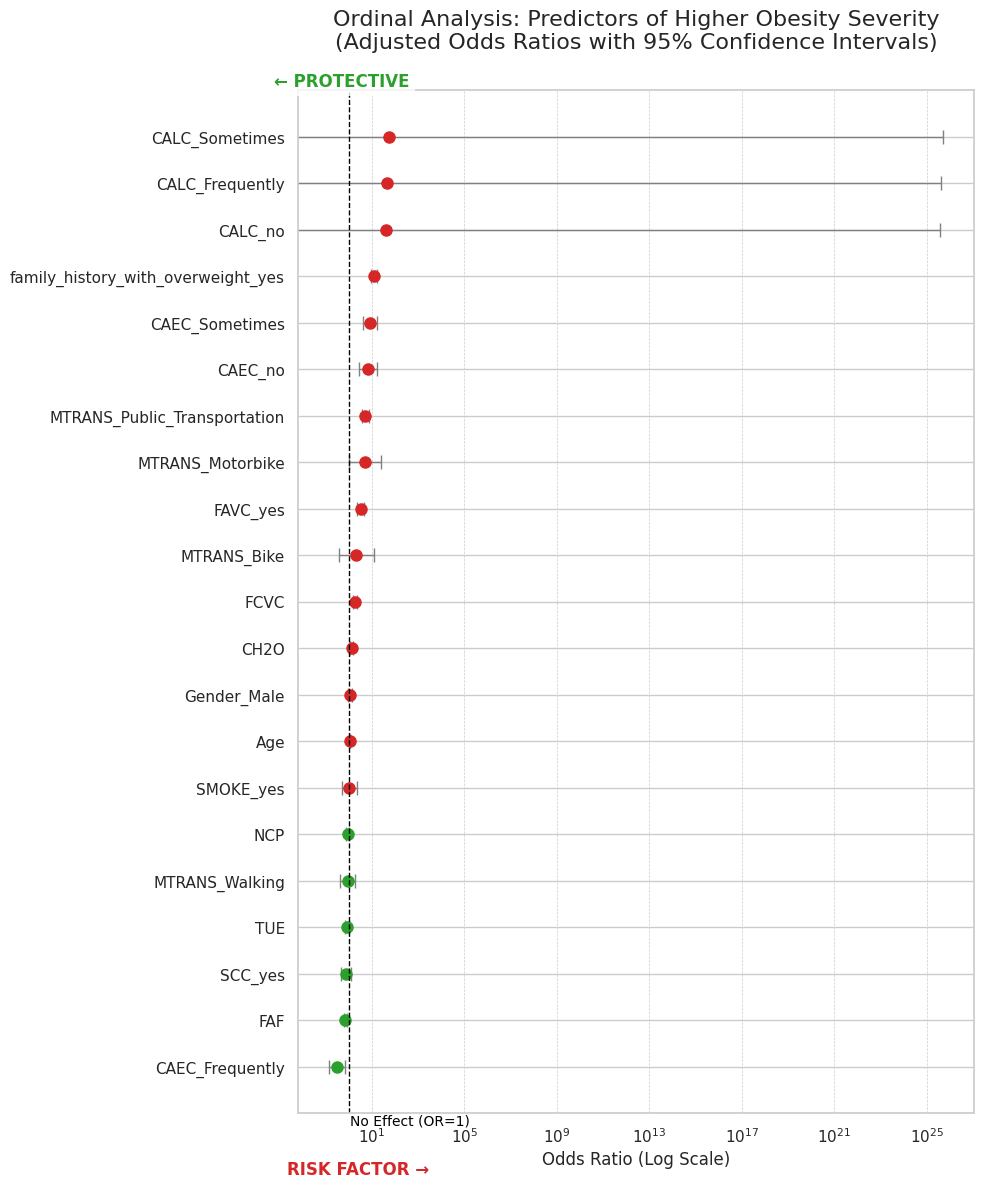


Top 5 Strongest Risk Factors (OR > 1)
                                           OR
CALC_Sometimes                      56.456575
CALC_Frequently                     45.302612
CALC_no                             41.503383
family_history_with_overweight_yes  12.952351
CAEC_Sometimes                       8.244813


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from ucimlrepo import fetch_ucirepo

# Style for graphs
sns.set_theme(style="whitegrid")

# Load Data
print("Fetching data...")
try:
    dataset = fetch_ucirepo(id=544)
    df = dataset.data.original
    print("Data loaded from UCI Library.")
except:
    # FIX: Replaced invalid .git URL with a working Raw CSV link
    url = "https://github.com/christian-ian-dev/Estimation-of-Obesity-Levels.git"
    df = pd.read_csv(url)
    print("Data loaded from Backup CSV.")

# Prepare Outcome
obesity_mapping = {
    'Insufficient_Weight': 'Normal',
    'Normal_Weight': 'Normal',
    'Overweight_Level_I': 'Overweight',
    'Overweight_Level_II': 'Overweight',
    'Obesity_Type_I': 'Obese',
    'Obesity_Type_II': 'Obese',
    'Obesity_Type_III': 'Obese'
}

df['Obesity_Level'] = df['NObeyesdad'].map(obesity_mapping)

cat_dtype = pd.CategoricalDtype(
    categories=['Normal', 'Overweight', 'Obese'],
    ordered=True
)
df['Obesity_Level'] = df['Obesity_Level'].astype(cat_dtype)
df['Obesity_Code'] = df['Obesity_Level'].cat.codes

# Prepare Predictors
# Remove Weight/Height to prevent model crash
X = df.drop(columns=['NObeyesdad', 'Obesity_Level', 'Obesity_Code', 'Weight', 'Height'])

# Convert categorical to dummy variables
X = pd.get_dummies(X, drop_first=True)
X = X.astype(float)

# Fit Ordinal Model
print("Fitting Model...")
mod_prob = OrderedModel(df['Obesity_Code'], X, distr='logit')
res_log = mod_prob.fit(method='bfgs', disp=False)

# Results for Graphing
conf = res_log.conf_int()
conf.columns = ['Lower_Log', 'Upper_Log']

# Convert to Odds Ratios
conf['OR'] = np.exp(res_log.params)
conf['Lower CI'] = np.exp(conf['Lower_Log'])
conf['Upper CI'] = np.exp(conf['Upper_Log'])

# Exclude Cut-points
predictors = conf.drop(index=[i for i in conf.index if '/' in str(i)]).copy()

# FILTER: Remove infinite or NaN values
predictors = predictors.replace([np.inf, -np.inf], np.nan).dropna()

# Sort by Odds Ratio
predictors = predictors.sort_values(by='OR', ascending=True)

# Define Colors
predictors['Color'] = ['#d62728' if x > 1 else '#2ca02c' for x in predictors['OR']]

# Create Forest Plot
plt.figure(figsize=(10, 12))

# Calculate Error Bars
lower_error = (predictors['OR'] - predictors['Lower CI']).abs()
upper_error = (predictors['Upper CI'] - predictors['OR']).abs()
errors = [lower_error, upper_error]

# Plot Error Bars
plt.errorbar(x=predictors['OR'],
             y=predictors.index,
             xerr=errors,
             fmt='o',
             ecolor='gray',
             capsize=5,
             color='black',
             markersize=0,
             linewidth=1)

# Plot Colored Dots
for i, row in enumerate(predictors.itertuples()):
    plt.plot(row.OR, row.Index, 'o', color=row.Color, markersize=8)

# Reference Line at 1
plt.axvline(x=1, color='black', linestyle='--', linewidth=1)


# PROTECTIVE -> Top Left
plt.text(0.5, len(predictors), '← PROTECTIVE',
         ha='center', va='bottom', color='#2ca02c', fontweight='bold', fontsize=12,
         bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))

# 2. RISK FACTOR -> Bottom Right
plt.text(2.5, -2, 'RISK FACTOR →',
         ha='center', va='top', color='#d62728', fontweight='bold', fontsize=12,
         bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))

# 3. No Effect Label -> Middle Bottom
plt.text(1.1, -1, 'No Effect (OR=1)', fontsize=10, color='black', va='top')

# Formatting
plt.title('Ordinal Analysis: Predictors of Higher Obesity Severity\n(Adjusted Odds Ratios with 95% Confidence Intervals)', fontsize=16, pad=30)
plt.xlabel('Odds Ratio (Log Scale)', fontsize=12)
plt.xscale('log')

plt.grid(True, which='both', linestyle='--', linewidth=0.5, axis='x')
plt.tight_layout()

print("\nGraph Generated Below:")
plt.show()

print("\nTop 5 Strongest Risk Factors (OR > 1)")
print(predictors[predictors['OR'] > 1].sort_values(by='OR', ascending=False)[['OR']].head(5))

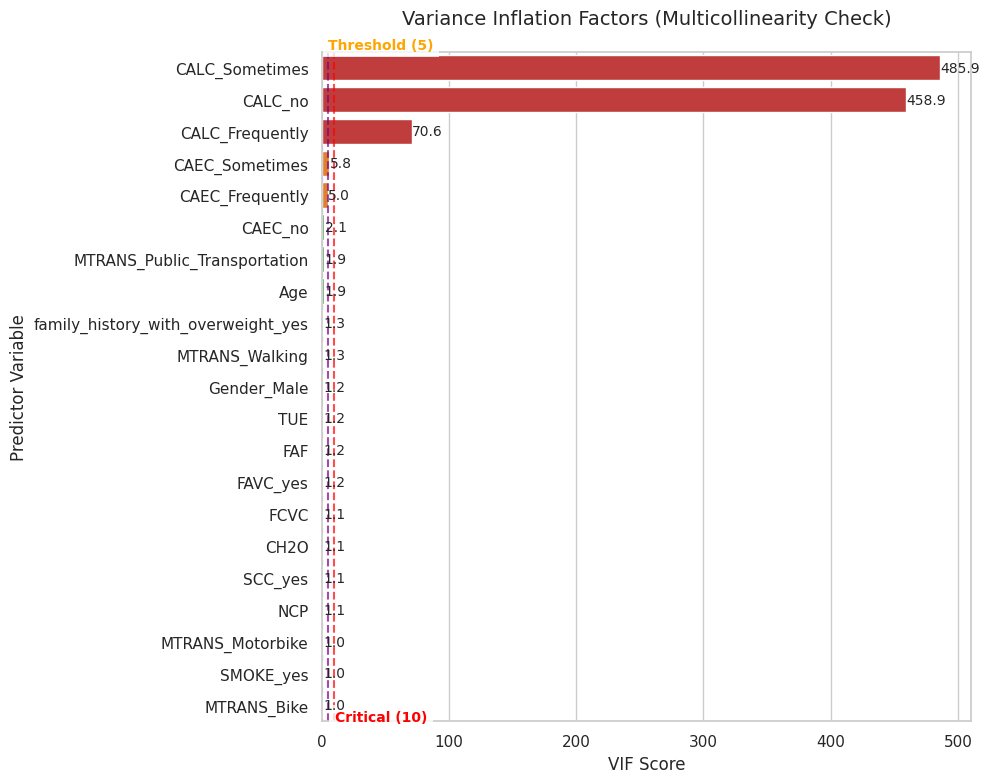

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF
X_vif = sm.add_constant(X.astype(float))

# VIF list
vif_list = [variance_inflation_factor(X_vif.values, i)
            for i in range(len(X_vif.columns))]

# Data Frame
vif_data = pd.DataFrame({
    "feature": X_vif.columns,
    "VIF": vif_list
})

# Filter and Sort: Remove 'const' (intercept)
plot_data = vif_data[vif_data['feature'] != 'const'].sort_values(by='VIF', ascending=False)

# Define colors based on VIF thresholds
color_list = ['#2ca02c' if x < 5 else '#ff7f0e' if x < 10 else '#d62728' for x in plot_data['VIF']]

# Create Graph
plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid")

# Create Bar Plot
ax = sns.barplot(
    data=plot_data,
    x='VIF',
    y='feature',
    hue='feature',
    palette=color_list,
    legend=False
)


# Threshold Line (5) -> LABEL AT TOP
plt.axvline(x=5, color='purple', linestyle='--', linewidth=1.5, alpha=0.7)
plt.text(5.2, -0.6, 'Threshold (5)', color='orange', fontsize=10, fontweight='bold',
         bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))

# Critical Line (10) -> LABEL AT BOTTOM
plt.axvline(x=10, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
# We place this at the bottom by using len(plot_data) - 0.5
plt.text(10.2, len(plot_data) - 0.5, 'Critical (10)', color='red', fontsize=10, fontweight='bold',
         bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))

# Formatting
plt.title('Variance Inflation Factors (Multicollinearity Check)', fontsize=14, pad=20)
plt.xlabel('VIF Score', fontsize=12)
plt.ylabel('Predictor Variable', fontsize=12)

# Value labels to the end of each bar
for index, value in enumerate(plot_data['VIF']):
    plt.text(value + 0.2, index, f'{value:.1f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

Loading Data...
Data loaded via Library.


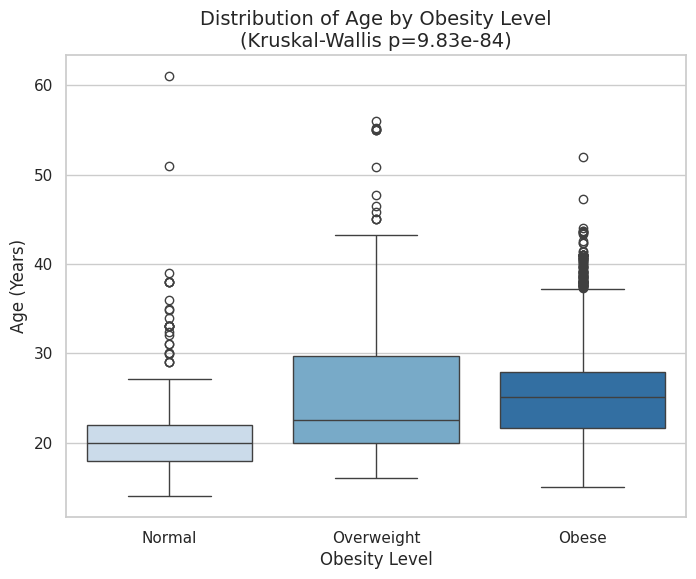

 AGE STATISTICS
Global Kruskal-Wallis p-value: 9.8314e-84

Post-Hoc Pairwise Comparisons (Dunn's Test):
                  Normal    Overweight         Obese
Normal      1.000000e+00  2.236836e-36  8.423631e-84
Overweight  2.236836e-36  1.000000e+00  2.589642e-07
Obese       8.423631e-84  2.589642e-07  1.000000e+00




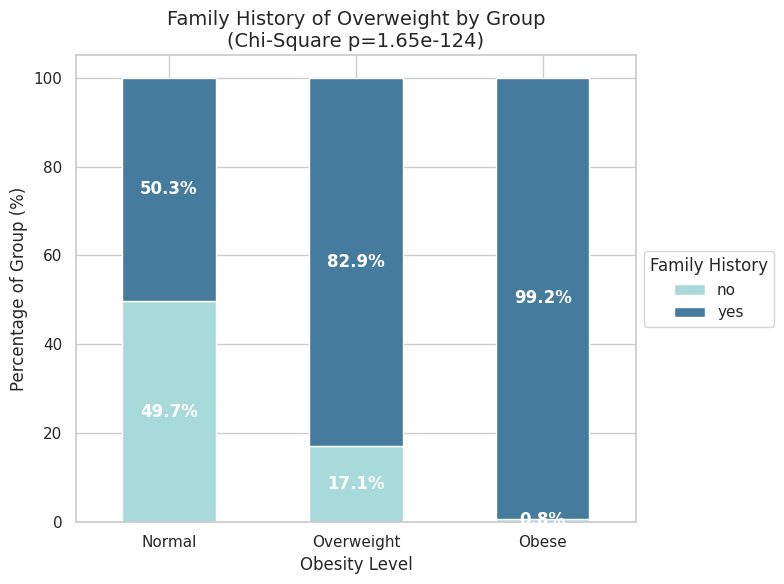

FAMILY HISTORY STATISTICS
Global Chi-Square p-value: 1.6476e-124

Proportions (Row %):
family_history_with_overweight         no        yes
Obesity_Level                                       
Normal                          49.731664  50.268336
Overweight                      17.068966  82.931034
Obese                            0.823045  99.176955


In [13]:
!pip install scikit-posthocs ucimlrepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scikit_posthocs as sp
from ucimlrepo import fetch_ucirepo

# Style for graphs
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Load Data
print("Loading Data...")
try:
    dataset = fetch_ucirepo(id=544)
    df = dataset.data.original
    print("Data loaded via Library.")
except:

    url = "https://github.com/christian-ian-dev/Estimation-of-Obesity-Levels.git"
    df = pd.read_csv(url)
    print("Data loaded via Backup CSV.")

# Map and Order Obesity Levels
obesity_mapping = {
    'Insufficient_Weight': 'Normal',
    'Normal_Weight': 'Normal',
    'Overweight_Level_I': 'Overweight',
    'Overweight_Level_II': 'Overweight',
    'Obesity_Type_I': 'Obese',
    'Obesity_Type_II': 'Obese',
    'Obesity_Type_III': 'Obese'
}
df['Obesity_Level'] = df['NObeyesdad'].map(obesity_mapping)

# Define precise order for graphing
order_list = ['Normal', 'Overweight', 'Obese']
df['Obesity_Level'] = pd.Categorical(df['Obesity_Level'], categories=order_list, ordered=True)

# ==========================================
# PART A: AGE (Continuous) - Boxplot & Test
# ==========================================

# Kruskal-Wallis Test
groups = [df[df['Obesity_Level'] == level]['Age'] for level in order_list]
stat, p_val = stats.kruskal(*groups)

# Create  Boxplot
plt.figure(figsize=(8, 6))

sns.boxplot(
    data=df,
    x='Obesity_Level',
    y='Age',
    order=order_list,
    hue='Obesity_Level',
    palette="Blues",
    legend=False
)

plt.title(f'Distribution of Age by Obesity Level\n(Kruskal-Wallis p={p_val:.2e})', fontsize=14)
plt.ylabel('Age (Years)', fontsize=12)
plt.xlabel('Obesity Level', fontsize=12)
plt.show()

# Statistical Details
print(f" AGE STATISTICS")
print(f"Global Kruskal-Wallis p-value: {p_val:.4e}")
if p_val < 0.05:
    print("\nPost-Hoc Pairwise Comparisons (Dunn's Test):")
    # Dunn's test with Bonferroni correction
    dunn = sp.posthoc_dunn(df, val_col='Age', group_col='Obesity_Level', p_adjust='bonferroni')
    print(dunn)
else:
    print("No significant difference in Age across groups.")

print("\n" + "="*60 + "\n")

# ==========================================
# PART B: FAMILY HISTORY (Categorical) - Stacked Bar & Test
# ==========================================

# Chi-Square Test
contingency = pd.crosstab(df['family_history_with_overweight'], df['Obesity_Level'])
chi2, p_chi, dof, ex = stats.chi2_contingency(contingency)

# Create Stacked Bar Chart: Calculate percentages for the graph
props = pd.crosstab(df['Obesity_Level'], df['family_history_with_overweight'], normalize='index') * 100

# Plotting
ax = props.plot(kind='bar', stacked=True, color=['#a8dadc', '#457b9d'], figsize=(8, 6))

# Formatting
plt.title(f'Family History of Overweight by Group\n(Chi-Square p={p_chi:.2e})', fontsize=14)
plt.ylabel('Percentage of Group (%)', fontsize=12)
plt.xlabel('Obesity Level', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Family History', loc='center left', bbox_to_anchor=(1, 0.5))

# Percentage labels on the bars
for c in ax.containers:
    ax.bar_label(c, fmt='%.1f%%', label_type='center', color='white', weight='bold')

plt.tight_layout()
plt.show()

# Print Statistical Details
print(f"FAMILY HISTORY STATISTICS")
print(f"Global Chi-Square p-value: {p_chi:.4e}")
print("\nProportions (Row %):")
print(props)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.9/218.9 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 11.1 MB/s eta 0:00:00
Fetching data...

Running Bayesian Model: Stage 1 (Normal -> Overweight)


Output()


Running Bayesian Model: Stage 2 (Overweight -> Obese)


Output()


RESULTS: STAGE 1 (Normal -> Overweight)
                                     Mean Effect  Lower 94% Limit  \
Age                                        0.137            0.112   
High_Calorie_Food[yes]                     0.283           -0.059   
Intercept                                 -4.220           -4.889   
family_history_with_overweight[yes]        1.391            1.110   

                                     Upper 94% Limit  \
Age                                            0.165   
High_Calorie_Food[yes]                         0.598   
Intercept                                     -3.518   
family_history_with_overweight[yes]            1.646   

                                     Effective Sample Size (Bulk)  
Age                                                        2114.0  
High_Calorie_Food[yes]                                     3089.0  
Intercept                                                  3005.0  
family_history_with_overweight[yes]                        2

<Figure size 1200x800 with 0 Axes>

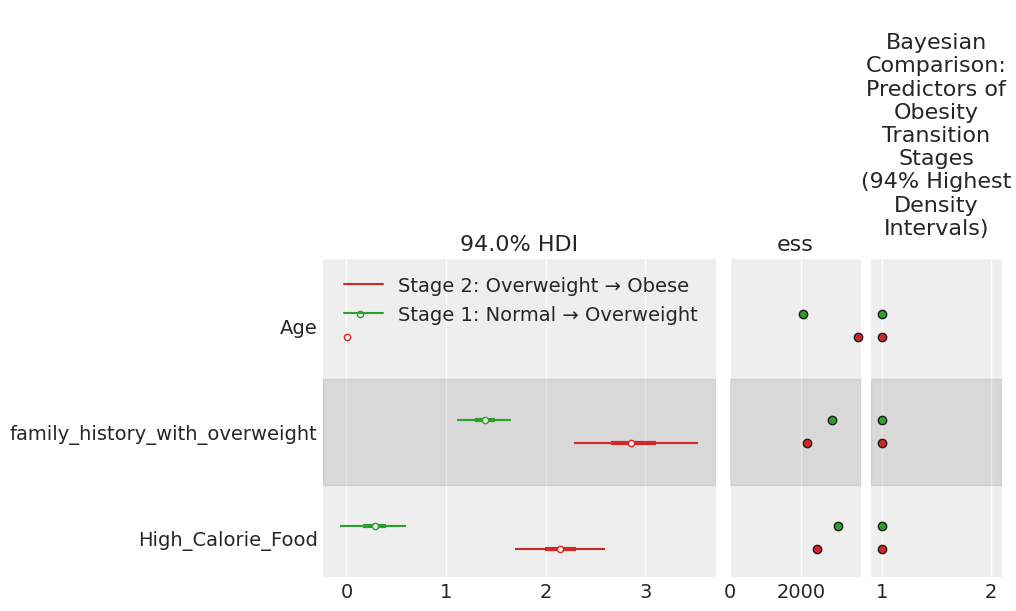

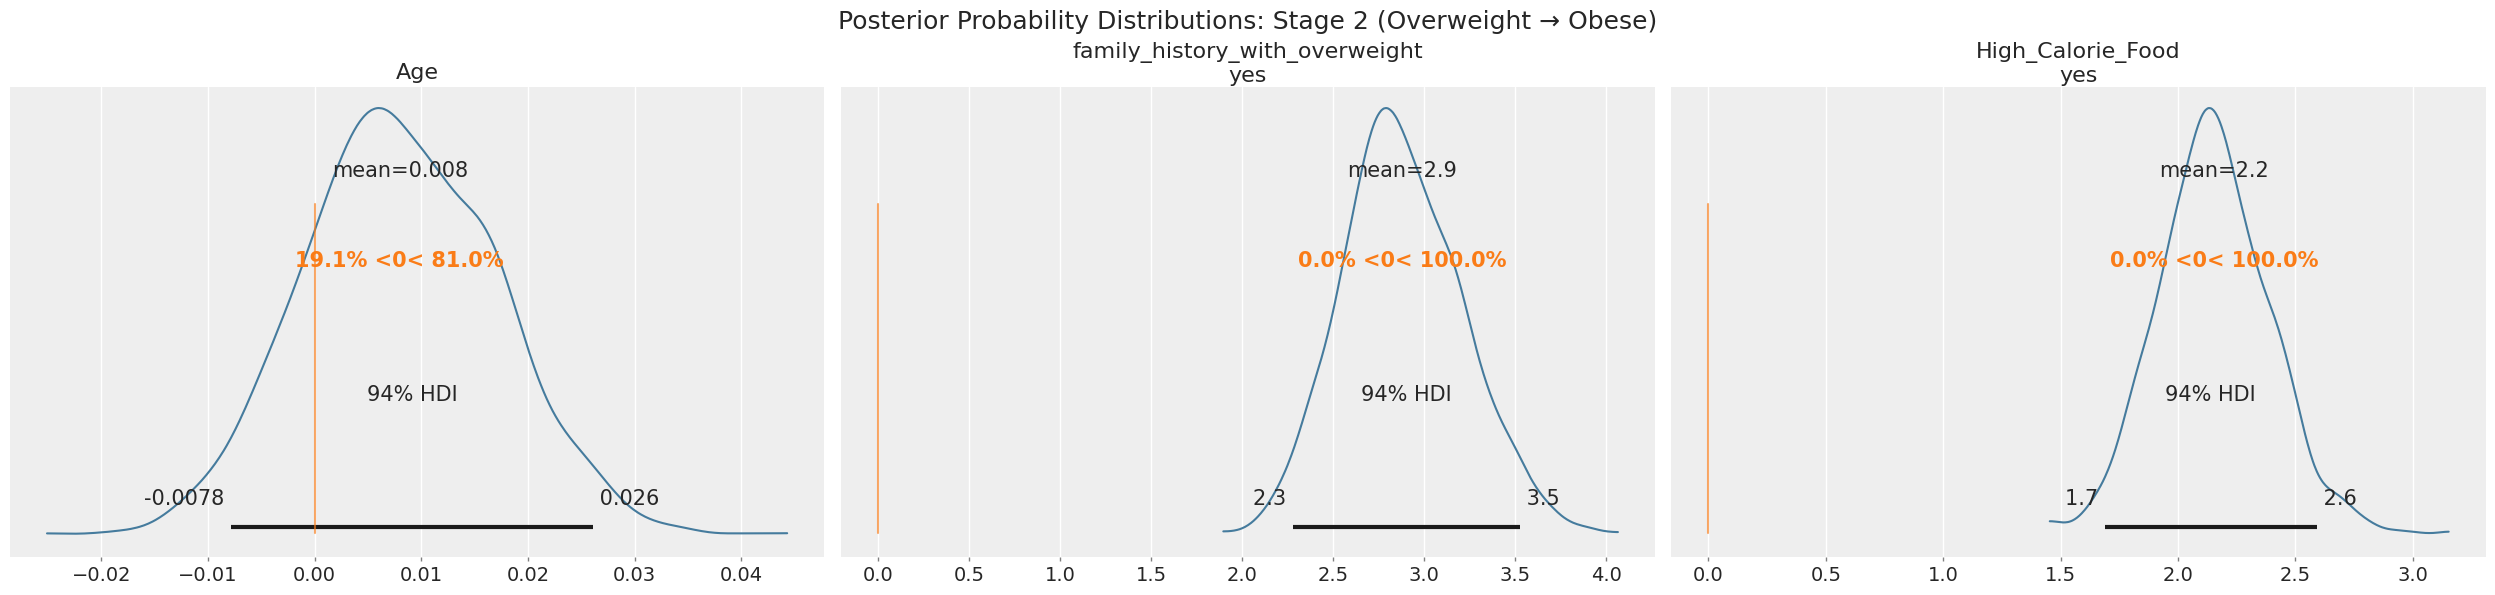

In [15]:
!pip install bambi pymc arviz ucimlrepo

import pandas as pd
import numpy as np
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo

# Plot style
az.style.use("arviz-darkgrid")

# Load Data
print("Fetching data...")
try:
    dataset = fetch_ucirepo(id=544)
    df = dataset.data.original
except:
    url = "https://github.com/christian-ian-dev/Estimation-of-Obesity-Levels.git"
    df = pd.read_csv(url)

# Map Obesity Levels
obesity_mapping = {
    'Insufficient_Weight': 'Normal', 'Normal_Weight': 'Normal',
    'Overweight_Level_I': 'Overweight', 'Overweight_Level_II': 'Overweight',
    'Obesity_Type_I': 'Obese', 'Obesity_Type_II': 'Obese', 'Obesity_Type_III': 'Obese'
}
df['Obesity_Level'] = df['NObeyesdad'].map(obesity_mapping)

# Name Column for Better Labels in Graphs
df.rename(columns={'FAVC': 'High_Calorie_Food'}, inplace=True)

# Define Model
def run_bayesian_stage(data, group0, group1, stage_name):
    print(f"\nRunning Bayesian Model: {stage_name} ({group0} -> {group1})")

    # Filter
    subset = data[data['Obesity_Level'].isin([group0, group1])].copy()
    subset['target'] = np.where(subset['Obesity_Level'] == group1, 1, 0)

    # Define Model (Using the NEW column name 'High_Calorie_Food')
    model = bmb.Model("target ~ Age + family_history_with_overweight + High_Calorie_Food",
                      data=subset, family="bernoulli")

    # Fit
    results = model.fit(draws=1000, chains=2)

    # Return both results
    return results, az.summary(results)

# Run Both Stages

# Stage 1: Normal -> Overweight
trace_stage1, summary_stage1 = run_bayesian_stage(df, 'Normal', 'Overweight', "Stage 1")

# Stage 2: Overweight -> Obese
trace_stage2, summary_stage2 = run_bayesian_stage(df, 'Overweight', 'Obese', "Stage 2")

# Print Summary Tables

def print_clean_summary(summary, title):

    summary = summary.rename(columns={
        'ess_bulk': 'Effective Sample Size (Bulk)',
        'ess_tail': 'Effective Sample Size (Tail)',
        'mean': 'Mean Effect',
        'sd': 'Std Dev',
        'hdi_3%': 'Lower 94% Limit',
        'hdi_97%': 'Upper 94% Limit'
    })

    print("\n" + "="*60)
    print(f"RESULTS: {title}")
    print("="*60)

    print(summary[['Mean Effect', 'Lower 94% Limit', 'Upper 94% Limit', 'Effective Sample Size (Bulk)']])

print_clean_summary(summary_stage1, "STAGE 1 (Normal -> Overweight)")
print_clean_summary(summary_stage2, "STAGE 2 (Overweight -> Obese)")

# Visualize Bayesian Results
print("\nGenerating Graphs...")

# GRAPH A: Forest Plot (Compare Stage 1 vs Stage 2)
plt.figure(figsize=(12, 8))
axes = az.plot_forest(
    [trace_stage1, trace_stage2],
    model_names=["Stage 1: Normal → Overweight", "Stage 2: Overweight → Obese"],
    var_names=["Age", "family_history_with_overweight", "High_Calorie_Food"],
    combined=True,
    figsize=(10, 6),
    colors=["#2ca02c", "#d62728"],
    ess=True,
    r_hat=True
)

# Set Main Title for Forest Plot
plt.title("Bayesian Comparison: Predictors of Obesity Transition Stages\n(94% Highest Density Intervals)", fontsize=16, pad=20)
plt.axvline(x=0, color='black', linestyle='--')
plt.show()

# GRAPH B: Posterior Distributions (Detailed View)
# Plot Stage 2 (Overweight -> Obese)
axes_post = az.plot_posterior(
    trace_stage2,
    var_names=["Age", "family_history_with_overweight", "High_Calorie_Food"],
    ref_val=0,
    color="#457b9d"
)

# Main Title for Posterior Plot
plt.suptitle("Posterior Probability Distributions: Stage 2 (Overweight → Obese)", fontsize=18, y=1.05)
plt.show()